In [1]:
import os

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import torch
import torch.nn.functional as F
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
import torch_geometric.transforms as T
from torch_geometric.utils import negative_sampling
from torch_geometric.data import DataLoader
from torch_geometric.nn import SAGEConv
import seaborn as sns
import matplotlib.pyplot as plt

Using backend: pytorch


In [3]:
dataset = PygNodePropPredDataset(name='ogbn-arxiv', 
                                 root='../../data/dataset/',
                                 transform=T.ToSparseTensor())
dataset

PygNodePropPredDataset()

In [4]:
MODEL_NB_NUMBER = 52
output_emb_file = f'../../models/graphsage_link_pred/full_graphsage_linkpred_{MODEL_NB_NUMBER}_h.npy'
losses_path = f'../../data/results/graphsage_link_pred/{MODEL_NB_NUMBER}_losses.csv'

In [5]:
losses = pd.read_csv(losses_path)
idxmin = losses['valid_loss'].idxmin()
epoch = int(losses.loc[idxmin, 'epoch'])
f'{epoch:04d}'

'0185'

In [6]:
model_path = f'../../models/graphsage_link_pred/{MODEL_NB_NUMBER}_model_epoch{epoch:04d}.pt'
embedding_path = f'../../models/graphsage_link_pred/{MODEL_NB_NUMBER}_embedding_epoch{epoch:04d}.pt'
predictor_path = f'../../models/graphsage_link_pred/{MODEL_NB_NUMBER}_predictor_epoch{epoch:04d}.pt'

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

In [8]:
data = dataset[0]
data

Data(adj_t=[169343, 169343, nnz=1166243], node_year=[169343, 1], x=[169343, 128], y=[169343, 1])

In [9]:
data.adj_t = data.adj_t.to_symmetric()
data.adj_t

SparseTensor(row=tensor([     0,      0,      0,  ..., 169341, 169342, 169342]),
             col=tensor([   411,    640,   1162,  ..., 163274,  27824, 158981]),
             size=(169343, 169343), nnz=2315598, density=0.01%)

In [10]:
class SAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers,
                 dropout):
        super(SAGE, self).__init__()

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

        self.dropout = dropout

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()

    def forward(self, x, adj_t):
        for conv in self.convs[:-1]:
            x = conv(x, adj_t)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.convs[-1](x, adj_t)
        return x


class LinkPredictor(torch.nn.Module):
    def __init__(self, out_channels, bias=True):
        super(LinkPredictor, self).__init__()
        self.lin = torch.nn.Linear(1, out_channels, bias=bias)

    def reset_parameters(self):
        self.lin.weight.data.fill_(1)
        self.lin.bias.data.fill_(0)

    def forward(self, x_i, x_j):
        cos_sim = torch.sum(
            torch.mul(F.normalize(x_i), 
                      F.normalize(x_j)), 
            dim=1,
            keepdim=True
        )
        x = self.lin(cos_sim)
        return torch.sigmoid(x)

In [11]:
model = torch.load(model_path).to(device)
model.eval()
predictor = torch.load(predictor_path).to(device)
predictor.eval()
embedding = torch.load(embedding_path).to(device)
embedding.eval()
adj_t = data.adj_t.to(device)

In [12]:
h = model(embedding.weight, adj_t)

In [13]:
predictor(h[0:2], h[411:413])

tensor([[0.9783],
        [0.0750]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [14]:
np.save(output_emb_file, h.cpu().detach().numpy())

## Evaluating pred distribution of a node

In [15]:
node_idx = 0

In [16]:
row, col, _ = data.adj_t.coo()
edge_index = torch.stack([col, row], dim=0)
mask = row == node_idx

this_row = row[mask]
this_col = col[mask]

In [17]:
this_row

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

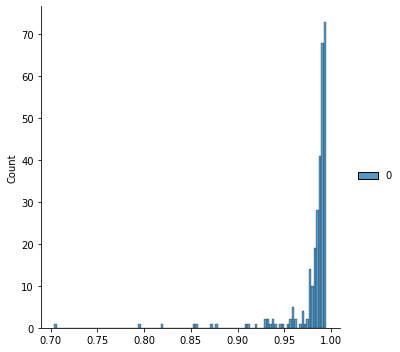

In [18]:
node_preds = predictor(h[this_row], h[this_col]).cpu().detach().numpy()
sns.displot(node_preds)

## Evaluating predictions of all edges

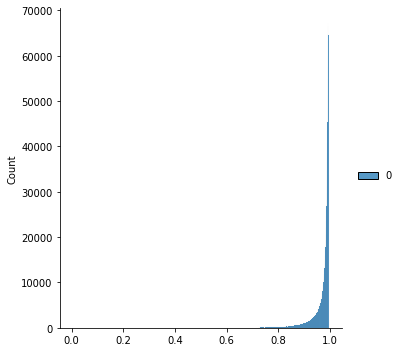

In [19]:
all_edges_preds = predictor(h[row], h[col]).cpu().detach().numpy()
sns.displot(all_edges_preds)

In [20]:
pd.Series(all_edges_preds.squeeze()).describe(percentiles=[0, 0.05, 0.1, 0.25])

count    2.315598e+06
mean     9.679139e-01
std      4.769666e-02
min      3.276947e-03
0%       3.276947e-03
5%       8.825542e-01
10%      9.237012e-01
25%      9.656665e-01
50%      9.850162e-01
max      9.952517e-01
dtype: float64

## Evaluating negative sampling predictions

In [21]:
neg_edges = negative_sampling(edge_index, num_nodes=data.adj_t.size(0),
                              num_neg_samples=100000, method='sparse')

In [22]:
neg_edges[0].size()

torch.Size([100000])

In [23]:
neg_edges_preds = predictor(h[neg_edges[0]], h[neg_edges[1]]).cpu().detach().numpy()

In [24]:
neg_edges_preds.shape

(100000, 1)

In [25]:
neg_edges_preds.max()

0.99442405

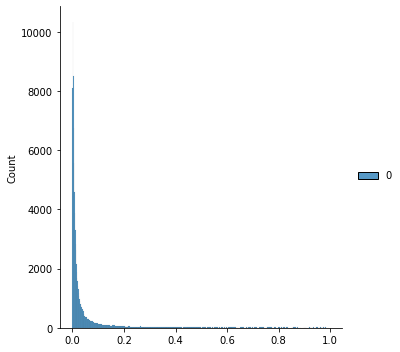

In [26]:
sns.displot(neg_edges_preds.round(4))

In [27]:
pd.Series(neg_edges_preds.squeeze()).describe(percentiles=[0, 0.05, 0.1, 0.25, 0.8, 0.9, 0.95])

count    100000.000000
mean          0.064200
std           0.150748
min           0.000091
0%            0.000091
5%            0.001225
10%           0.001906
25%           0.004261
50%           0.011654
80%           0.056596
90%           0.160202
95%           0.373020
max           0.994424
dtype: float64

## Cosine similarity of all edges

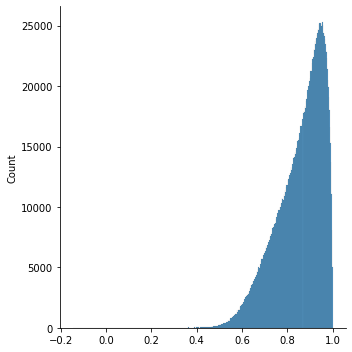

In [28]:
similarities = F.cosine_similarity(h[row], h[col]).cpu().detach().numpy()
sns.displot(similarities)

## Cosine similarity of negative edges

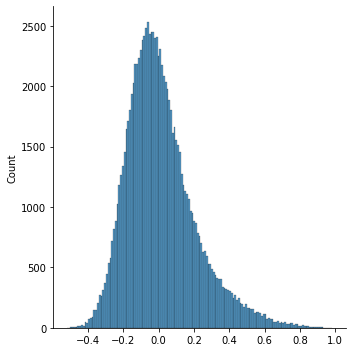

In [29]:
similarities = F.cosine_similarity(h[neg_edges[0]], h[neg_edges[1]]).cpu().detach().numpy()
sns.displot(similarities)

## Inner product of all edges

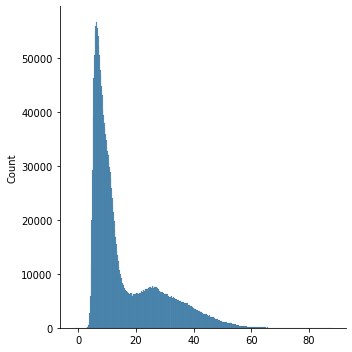

In [30]:
ip_pos = torch.sum(torch.mul(h[row], h[col]), dim=1).cpu().detach().numpy()
sns.displot(ip_pos)

In [31]:
ip_pos.mean()

15.845358

In [32]:
ip_pos.std()

11.869498

## Inner product of negative edges

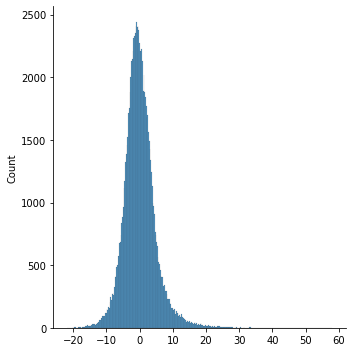

In [33]:
ip_neg = torch.sum(torch.mul(h[neg_edges[0]], h[neg_edges[1]]), dim=1).cpu().detach().numpy()
sns.displot(ip_neg)

In [34]:
ip_neg.mean()

0.040092293

In [35]:
ip_neg.std()

4.7968493